In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

from train_nn_full import train_nn
from KS_solver import KS_step, ml_step
import evaluation_metrics as em

import torch

from jax_models import *

In [81]:
from torch import nn
import torch.nn.functional as F

In [82]:
print(torch.backends.mps.is_available())

False


In [83]:
def f_rand(L):
    nwaves = 5
    a = np.arange(nwaves)+1
    b = np.random.rand(nwaves)
    d = np.random.rand(nwaves)

    xi = np.linspace(0,L,1000)
    fx = xi*0
    for i in range(nwaves):
        fx = fx + b[i]*np.sin(2*a[i]*np.pi*(xi-d[i])/L)
        
    mina = np.min(fx)
    maxa = np.max(fx)

    def f(x):
        fx = x*0
        for i in range(nwaves):
            fx = fx + b[i]*np.sin(2*a[i]*np.pi*(x-d[i])/L)
            
        fx = (fx - mina) / (maxa - mina)   
        return fx

    return f

In [84]:
# define our KS domain and system
dt = 0.25
s = 128
l=22
M=16
KS = KuramotoSivashinsky(dt=dt, s=s, l=l, M=M)

In [96]:
class Model(nn.Module):
    def __init__(self, hidden_dim, nmodes_full, nmodes, mode_mean):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.nmodes_full = nmodes_full
        self.nmodes = nmodes
        self.mode_mean = mode_mean

        
        self.fc1 = nn.Linear(nmodes*2, hidden_dim).double()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).double()
        self.fc3 = nn.Linear(hidden_dim,nmodes*2).double()
        self.act = nn.ELU()
    
    def forward(self, u):
        uout = self.fc3(self.act(self.fc2(self.act(self.fc1(u)))))
        
        return uout
    
    def prep_data(self, x, nmodes):
        x = get_fft(x, nmodes)
        x = x/self.mode_mean
        return x

    def inv_prep_data(self, y, nmodes_out):
        nx = y.shape[-1]//2+1
        y_shape = np.array(y.shape)
        print(nx)
        print(nmodes_out+1)
        y_shape[-1] = nmodes_out+1
        y_real = np.zeros(y_shape)

        y = y*self.mode_mean
        y_real[...,:nx] = y[...,:nx]
        y_im = y_real*0
        print(y.shape)
        print(y_im.shape)
        y_im[...,1:nx-1] = y[...,nx:]
        y = np.real(np.fft.irfft(y_real + y_im*1j))
        return y
    
def get_fft(x, nmodes):
    x = np.fft.rfft(x)
    x_real = np.real(x)
    x_im = np.imag(x)
    x = np.concatenate((x_real[...,:nmodes+1], x_im[...,1:nmodes]), axis=len(x.shape)-1)
    return x

# to use full spectrum of frequencies for an even nx, nmodes should be nmodes=nx/2 (the 0 mode is automatically included)
def train_nn(KS, dt, nx, nmodes, rollout,train_period, stencil, f_rand, n_epochs=10000,print_mes=True, nb=5):
    L = KS.l
    x = np.arange(0,L, L/nx)
    nmodes_full = nx//2
    assert(nx%2==0) #only positive nx

    # Get statistics of modes for processing data
    example = np.zeros((20, train_period+1, len(x)))
    for i in range(20):
        f = f_rand(KS.l)
        example[i,:,:] = KS_step(KS, train_period, f(x)) 
    example = get_fft(example, nmodes)
    mode_mean = np.mean(np.abs(example), axis=(0,1))
    weights = mode_mean**(1/12)
    mode_weights = torch.tensor(weights/np.sum(weights))
    print(mode_weights)

    # Instantiate the model with hyperparameters
    model = Model(100, nmodes_full, nmodes, mode_mean)

    # Define hyperparameters
    lr = 0.001

    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    with torch.autograd.set_detect_anomaly(True):
    
        for epoch in range(0, n_epochs):
            optimizer.zero_grad()

            target_seq = np.zeros((nb, train_period+1, len(x)))
            for i in range(nb):
                f = f_rand(KS.l)
                target_seq[i,:,:] = KS_step(KS, train_period, f(x)) 

             # imaginary coefficients for first and last must be real, so don't model them
            target_seq = model.prep_data(target_seq, nmodes)
            X = torch.tensor(target_seq[:,:-1].reshape(-1, target_seq.shape[2]))
            Y = torch.tensor(target_seq[:,1:].reshape(-1, target_seq.shape[2]))
            output = model(X)

            X_rollout = torch.tensor(X[:-10:2,:])
            Y_rollout = torch.tensor(X[5:-5:2,:])
            Y_rollout2 = torch.tensor(X[15:-5:2,:])

            Yi = X_rollout
            for i in range(rollout):
                Yi = model(Yi).clone()

            Yj = Yi[:-5].clone()
            for j in range(10):
                Yj = model(Yj).clone()
            
            loss = torch.mean((Y-output)**2*mode_weights) # don't include IC
            loss_rollout = torch.mean((Yi-Y_rollout)**2*mode_weights)
            loss_rollout2 = torch.mean((Yj-Y_rollout2)**2*mode_weights)
            loss = (loss+loss_rollout/rollout + loss_rollout2)/3*1e2
            print(epoch, 'loss: ', np.round(loss.detach().numpy(),6))
            loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly
            
    return model
    


In [105]:
rollout = 5
stencil = 50
nx = KS.s
train_period=500
nmodes=50
model = train_nn(KS, dt, nx,nmodes, rollout, train_period, stencil, f_rand, print_mes=True, nb=10, n_epochs=10000)

tensor([0.0269, 0.0238, 0.0258, 0.0251, 0.0246, 0.0226, 0.0215, 0.0199, 0.0185,
        0.0171, 0.0158, 0.0146, 0.0135, 0.0124, 0.0114, 0.0106, 0.0097, 0.0089,
        0.0082, 0.0075, 0.0069, 0.0064, 0.0060, 0.0057, 0.0057, 0.0056, 0.0057,
        0.0056, 0.0057, 0.0056, 0.0057, 0.0055, 0.0056, 0.0055, 0.0057, 0.0056,
        0.0057, 0.0056, 0.0057, 0.0056, 0.0057, 0.0056, 0.0057, 0.0056, 0.0057,
        0.0057, 0.0058, 0.0056, 0.0058, 0.0056, 0.0058, 0.0237, 0.0258, 0.0252,
        0.0246, 0.0226, 0.0215, 0.0199, 0.0185, 0.0171, 0.0158, 0.0146, 0.0135,
        0.0125, 0.0114, 0.0106, 0.0097, 0.0089, 0.0082, 0.0075, 0.0069, 0.0064,
        0.0060, 0.0057, 0.0057, 0.0056, 0.0057, 0.0056, 0.0057, 0.0056, 0.0057,
        0.0055, 0.0056, 0.0055, 0.0057, 0.0056, 0.0057, 0.0056, 0.0057, 0.0056,
        0.0057, 0.0056, 0.0057, 0.0056, 0.0057, 0.0057, 0.0058, 0.0056, 0.0058,
        0.0056], dtype=torch.float64)
0 loss:  1.439702
1 loss:  1.380428
2 loss:  1.404731
3 loss:  1.446414
4 loss:  1

In [106]:
# inputted as dimensions (time, x)
def nn_step(model, y0, num_steps, nmodes, all_steps=True):
    if len(y0.shape)==1:
        y0 = np.expand_dims(y0, 0)
    nmodes_og = y0.shape[-1]//2
    print('og', nmodes_og)
    y0 = model.prep_data(y0, nmodes)
    y_next = np.zeros((num_steps+1, y0.shape[-1]))
    y_next[0,:] = y0
    y_next = torch.tensor(y_next)
    for i in range(1,num_steps+1):
        f_t = model(y_next[i-1,:])
        y_next[i,:] = f_t

    # transpose back to (time,x)
    y_next = y_next.detach().numpy()
    y_next = model.inv_prep_data(y_next, nmodes_og)
    
    if all_steps:
        return y_next
    else:
        return y_next[-1]

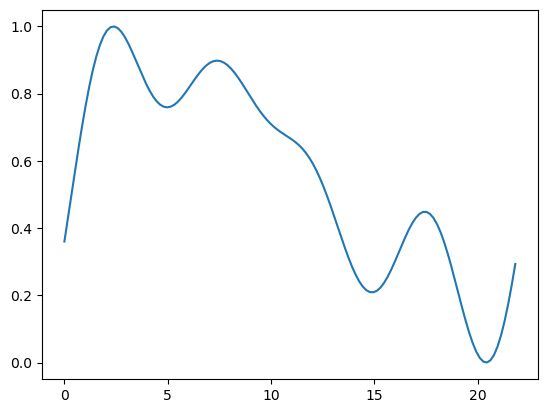

In [107]:
x = np.arange(0,l,l/s)
x_plot = np.linspace(0,l,s+1)
f = f_rand(l)
f0 = f(x)
plt.plot(x, f0)

In [108]:
q = np.array([[[1,2,3],[4,5,6]]])
q[...,:]

array([[[1, 2, 3],
        [4, 5, 6]]])

(1, 128)
og 64
51
65
(2001, 100)
(2001, 65)


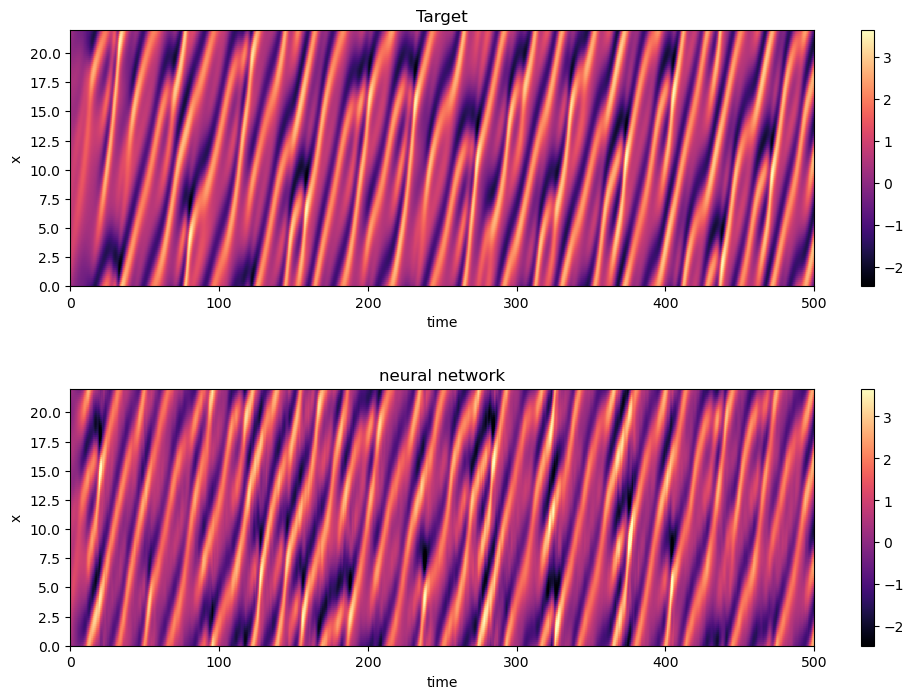

In [109]:
num_steps = 2000
t = np.arange(0, KS.dt*(num_steps+1-0.1), KS.dt)

data_result = KS_step(KS, num_steps, f0)
y0 = data_result[0:1]
print(y0.shape)
nn_result = nn_step(model, y0, num_steps, nmodes, all_steps=True)

vmax = np.max(data_result)
vmin = np.min(data_result)

fig, ax = plt.subplots(2,1, figsize=(12,8))

cm = ax[0].pcolormesh(t, x_plot, data_result[:-1].T, cmap='magma', vmax=vmax, vmin=vmin)
ax[0].set_xlabel('time')
ax[0].set_ylabel('x')
ax[0].set_title('Target')
plt.colorbar(cm, ax=ax[0])

ax[1].pcolormesh(t, x_plot, nn_result[:-1].T, cmap='magma', vmax=vmax, vmin=vmin)
ax[1].set_xlabel('time')
ax[1].set_ylabel('x')
ax[1].set_title('neural network')
plt.colorbar(cm, ax=ax[1])

plt.subplots_adjust(hspace=0.4)

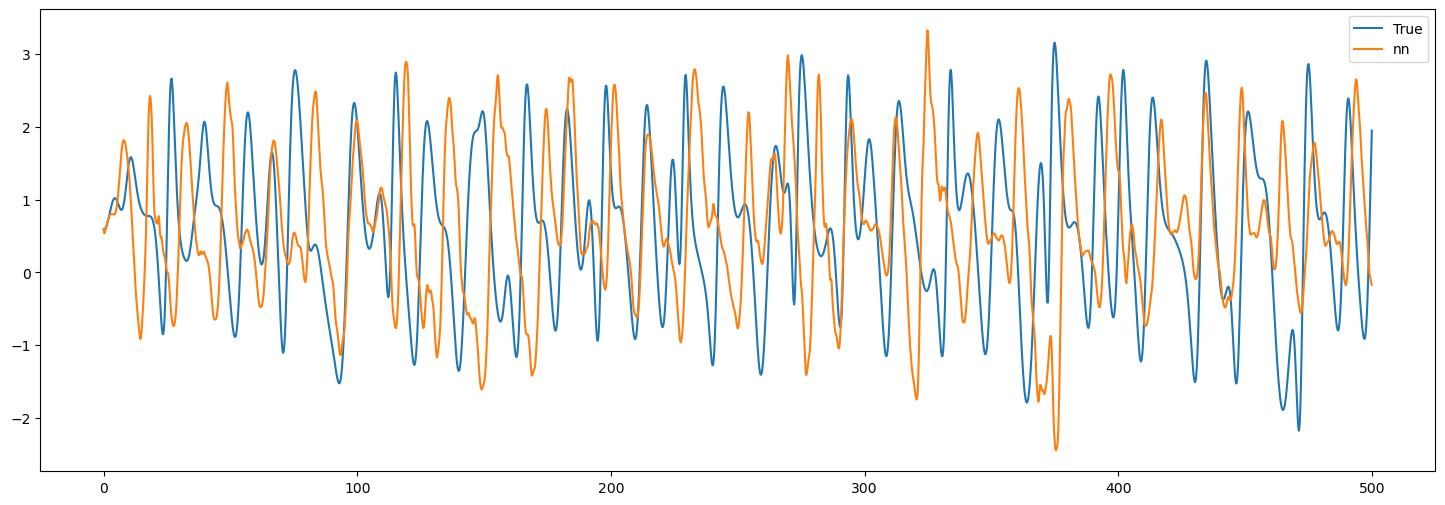

In [110]:
i=70
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(t, data_result[:,i], label='True')
plt.plot(t, nn_result[:,i], label='nn')
plt.legend()

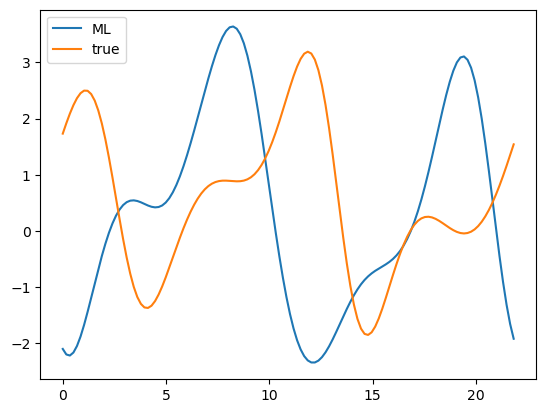

In [111]:
i = 1500
plt.plot(x, nn_result[i], label='ML')
plt.plot(x, data_result[i], label='true')
plt.legend()

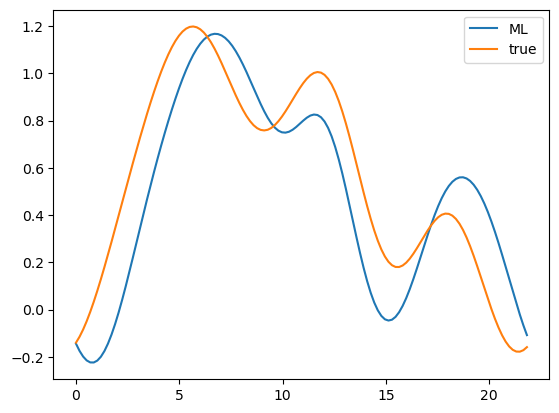

In [112]:
i = 15
plt.plot(x, nn_result[i], label='ML')
plt.plot(x, data_result[i], label='true')
plt.legend()

Histogram Kolmogorov-Smirnov Error: 0.037, p-value: 2.6e-153
TKE Kolmogorov-Smirnov Error: 0.36, p-value: 1.7e-114
Max Error in Spectrum: 2.8e+02 at frequency 0.18
Mean Squared Error in Autocorrelation: 3.6e+04


(<Figure size 700x600 with 1 Axes>,
 <Figure size 700x600 with 1 Axes>,
 <Figure size 800x800 with 1 Axes>,
 <Figure size 800x800 with 1 Axes>,
 KstestResult(statistic=0.03706740379810103, pvalue=2.557660202000665e-153, statistic_location=0.5929730985993238, statistic_sign=-1),
 KstestResult(statistic=0.3583208395802099, pvalue=1.7147908331552928e-114, statistic_location=0.8710866382014253, statistic_sign=-1))

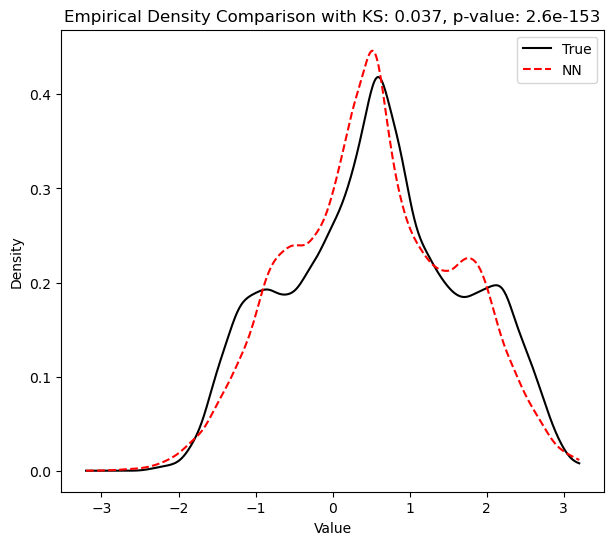

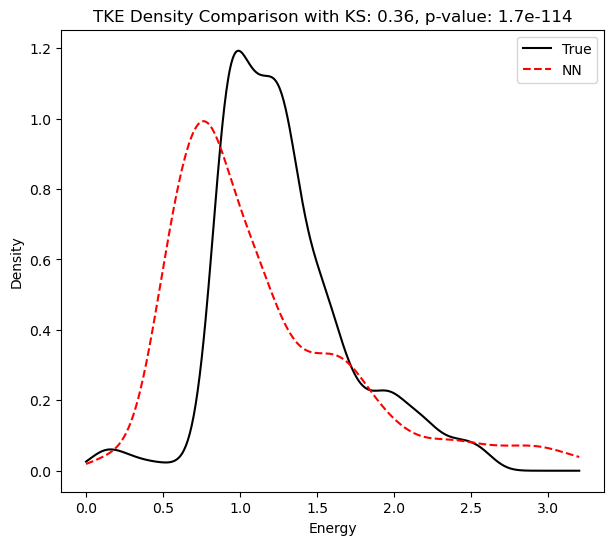

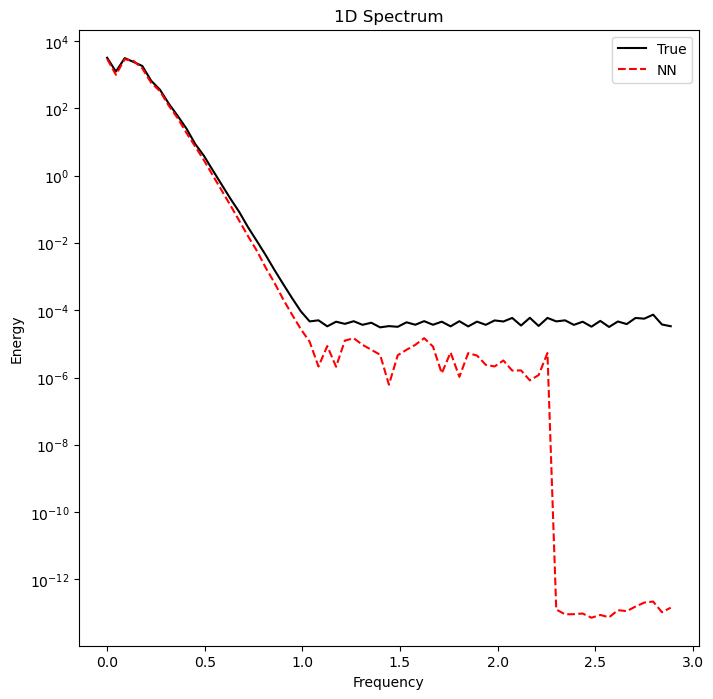

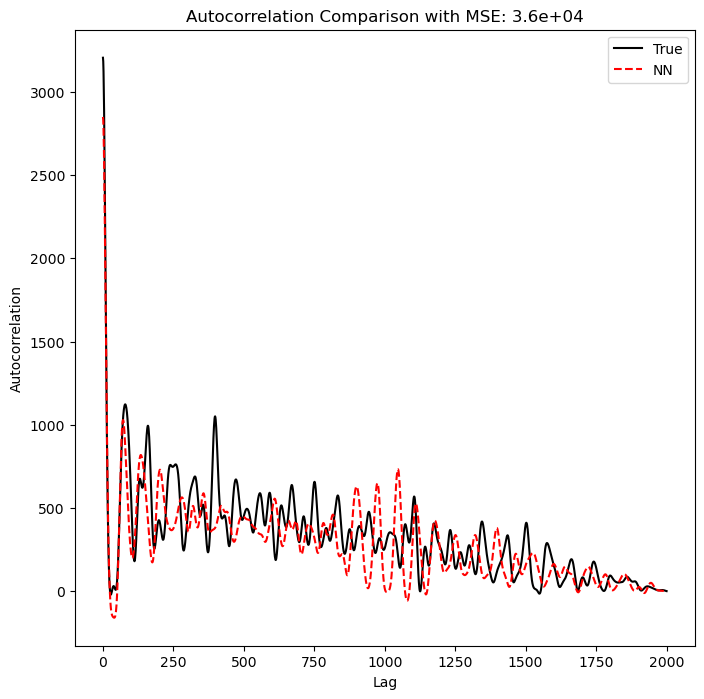

In [113]:
em.evaluate_metrics(data_result, nn_result, save_to_pdf = "results/modes50", l = KS.l, tke_plot_max_threshold = 3.2)

In [95]:
path = 'models'
torch.save(model.state_dict(), f"{path}/b_weight1e-12")